In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

import sys
sys.path.append("C:/Users/cnava/Repos/PolaPy")

from polapy.competitiveness import navarrete_etal as competitiveness
from polapy.polarization import navarrete_etal as polarization

os.chdir("../")

from epitools import get_data
from plots import set_plot

In [30]:
def bake_data(input_df, unit, aggregation="polling_id"):
    dd = input_df.groupby([unit, aggregation, "candidate"]).agg({"value": "sum"})
    dd["rate"] = dd.groupby(level=[0, 1], group_keys=False).apply(lambda x: x/x.sum())
    dd = dd.reset_index().rename(columns={aggregation: "polling_id"})
    
    return dd

In [43]:
country, year, election_round, aggregation, second_aggregation = "France", 2022, "first_round", "nuts_2", "commune_id"
country, year, election_round, aggregation, second_aggregation = "Chile", 2021, "first_round", "region_id", "commune"
country, year, election_round, aggregation, second_aggregation = "United States", 2020, "general", "state", "county_fips"

# country = "United States"
# year = 2020
# election_round = "general"
# aggregation = "state"

df = pd.read_csv(
    f"data_output/{country}/{year}_{election_round}.csv.gz",
    compression="gzip"
)

df_location = pd.read_csv(
    f"data_output/{country}/{year}_{election_round}_location.csv.gz",
    compression="gzip"
)

df = pd.merge(
    df.query("flag_candidates == 1"),
    df_location,
    on="polling_id"
)

if country == "France":
    candidates = df.groupby("candidate").agg({"value": "sum"}).sort_values("value", ascending=False).head(8).index
    df = df[df["candidate"].isin(candidates)]
    df["commune_id"] = df.apply(lambda x: f"75-{x['circunscription_id']}" if x["department_id"] == "75" else x["commune_id"], axis=1)

elif country == "United States":
    df = df[df["candidate"].isin(["JOSEPH R BIDEN", "DONALD J TRUMP"])].drop_duplicates()

df.head()

,polling_id,candidate,value,rate,rank,flag_candidates,region_id,region,province,senate_district,district,commune,electoral_circ,polling_place,polling_table,polling_type,mixed_polling,voters
0,ALGARROBO-ALGARROBO-1.0-M-1M,EDUARDO ARTES BRICHETTI,1.0,0.006024,7.0,1,5,DE VALPARAISO,SAN ANTONIO,6,7,ALGARROBO,ALGARROBO,LICEO TECNICO CARLOS ALESSANDRI ALTAMIRANO LOC...,1,M,1M,339
1,ALGARROBO-ALGARROBO-1.0-M-1M,FRANCO PARISI FERNANDEZ,14.0,0.084337,5.0,1,5,DE VALPARAISO,SAN ANTONIO,6,7,ALGARROBO,ALGARROBO,LICEO TECNICO CARLOS ALESSANDRI ALTAMIRANO LOC...,1,M,1M,339
2,ALGARROBO-ALGARROBO-1.0-M-1M,GABRIEL BORIC FONT,29.0,0.174699,3.0,1,5,DE VALPARAISO,SAN ANTONIO,6,7,ALGARROBO,ALGARROBO,LICEO TECNICO CARLOS ALESSANDRI ALTAMIRANO LOC...,1,M,1M,339
3,ALGARROBO-ALGARROBO-1.0-M-1M,JOSE ANTONIO KAST RIST,53.0,0.319277,1.0,1,5,DE VALPARAISO,SAN ANTONIO,6,7,ALGARROBO,ALGARROBO,LICEO TECNICO CARLOS ALESSANDRI ALTAMIRANO LOC...,1,M,1M,339
4,ALGARROBO-ALGARROBO-1.0-M-1M,MARCO ENRIQUEZ-OMINAMI GUMUCIO,10.0,0.060241,6.0,1,5,DE VALPARAISO,SAN ANTONIO,6,7,ALGARROBO,ALGARROBO,LICEO TECNICO CARLOS ALESSANDRI ALTAMIRANO LOC...,1,M,1M,339


In [44]:
df_a = bake_data(df, aggregation, aggregation=second_aggregation)
df_b = df.copy()

def get_ep_ec(input_df, aggregation, level):
    output = []
    for unit, tmp in input_df.groupby(aggregation):
        v_ec, ag = competitiveness(tmp, unit="polling_id", votes="value")
        v_ep, ag = polarization(tmp, unit="polling_id", votes="value")
    
        output.append({
            "geography_id": unit,
            "ec": v_ec,
            "ep": v_ep,
            "level": level
        })

    return pd.DataFrame(output)

df_a_ep = get_ep_ec(df_a, aggregation, level="Commune")
df_b_ep = get_ep_ec(df_b, aggregation, level="Precinct")

In [45]:
data = pd.concat([df_a_ep, df_b_ep])

if country == "France":
    data = data[~data["geography_id"].str.contains("FRZ")]
    data = data[~data["geography_id"].str.contains("FRY")]

elif country == "United States":
    data = data[~data["geography_id"].str.contains("DC")]
    data = data[~data["geography_id"].str.contains("DISTRICT OF COLUMBIA")]

data.head()

,geography_id,ec,ep,level
0,1,0.856784,0.031157,Commune
1,2,0.864568,0.020703,Commune
2,3,0.869751,0.034499,Commune
3,4,0.889803,0.019723,Commune
4,5,0.879028,0.027933,Commune


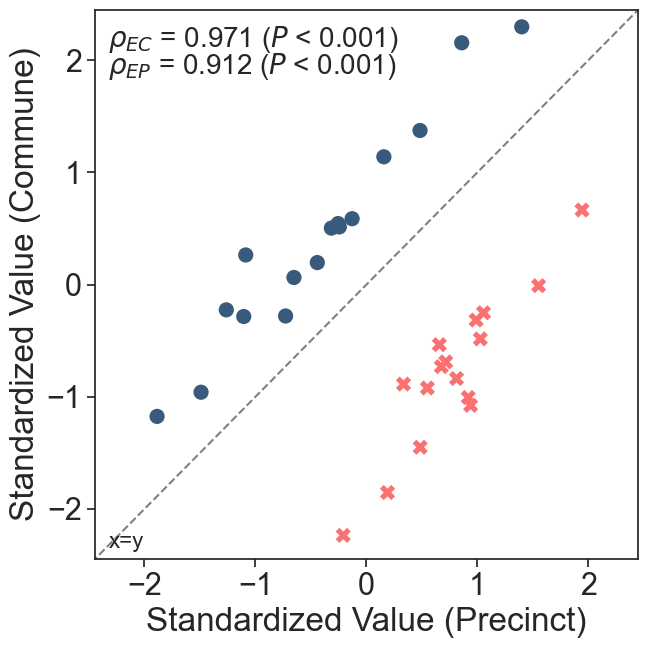

In [46]:
data2 = data.copy()
for col in ["ep", "ec"]:
    data2[col] = (data2[col] - data2[col].mean()) / data2[col].std()

data2 = data2.melt(id_vars=["geography_id", "level"], var_name="type")\
    .pivot(index=["geography_id", "type"], columns=["level"], values="value").reset_index()

data2 = data2.rename(columns={"Precinct": "x", "Commune": "y"})

sns.set(font_scale=2, style="ticks")

fig, ax = plt.subplots(figsize=(7, 7))
set_plot(data2, ax, xlabel="Standardized Value (Precinct)", ylabel="Standardized Value (Commune)", labelkey=None)

fig.tight_layout()